# Basic Tutorial: `GaussNoiseModel`

Trey V. Wenger (c) October 2024

This notebook is nearly identical to the basic tutorial, except we implement a new model called `GaussNoiseModel`. This model allows the spectral rms to be an inferred parameter. Such is a useful trick for complicated posterior distributions, such as when there are multiple, high signal-to-noise components.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.2+4.gfef408d.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

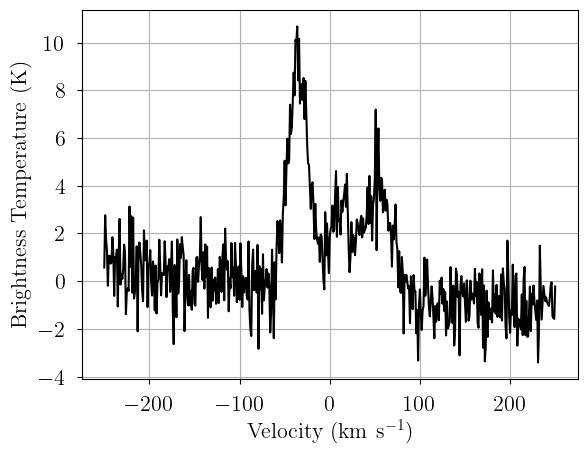

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

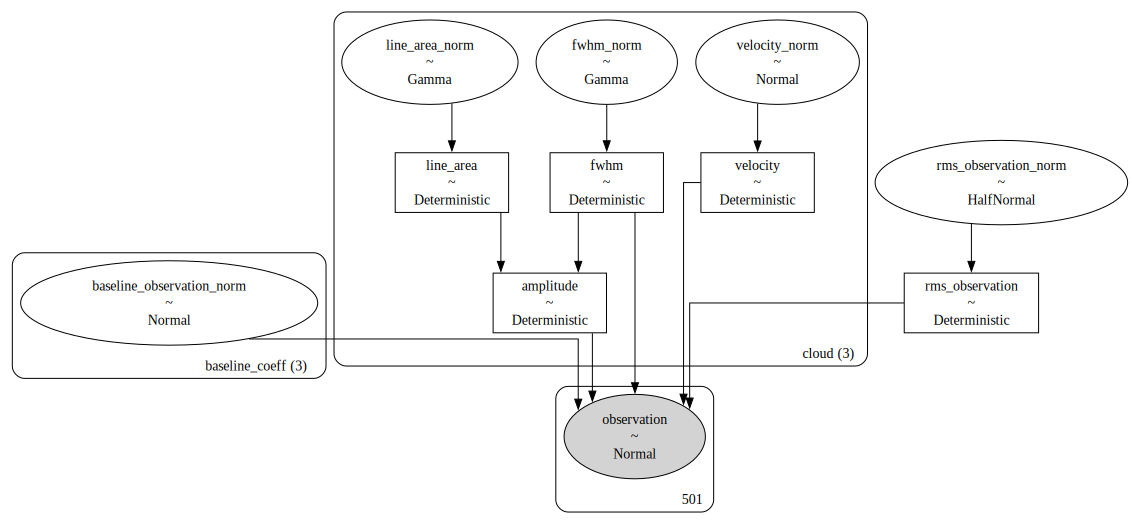

In [6]:
# Plot model graph
model.graph()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


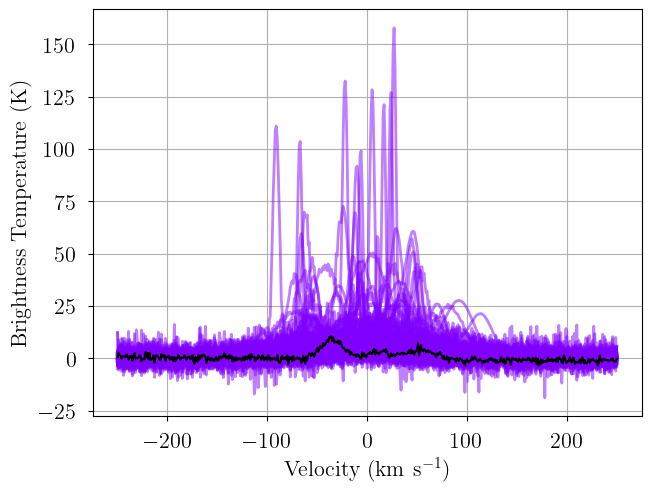

In [7]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

baseline_freeRVs ['baseline_observation_norm']
baseline_deterministics []
cloud_freeRVs ['line_area_norm', 'fwhm_norm', 'velocity_norm']
cloud_deterministics ['line_area', 'fwhm', 'velocity', 'amplitude']
hyper_freeRVs ['rms_observation_norm']
hyper_deterministics ['rms_observation']


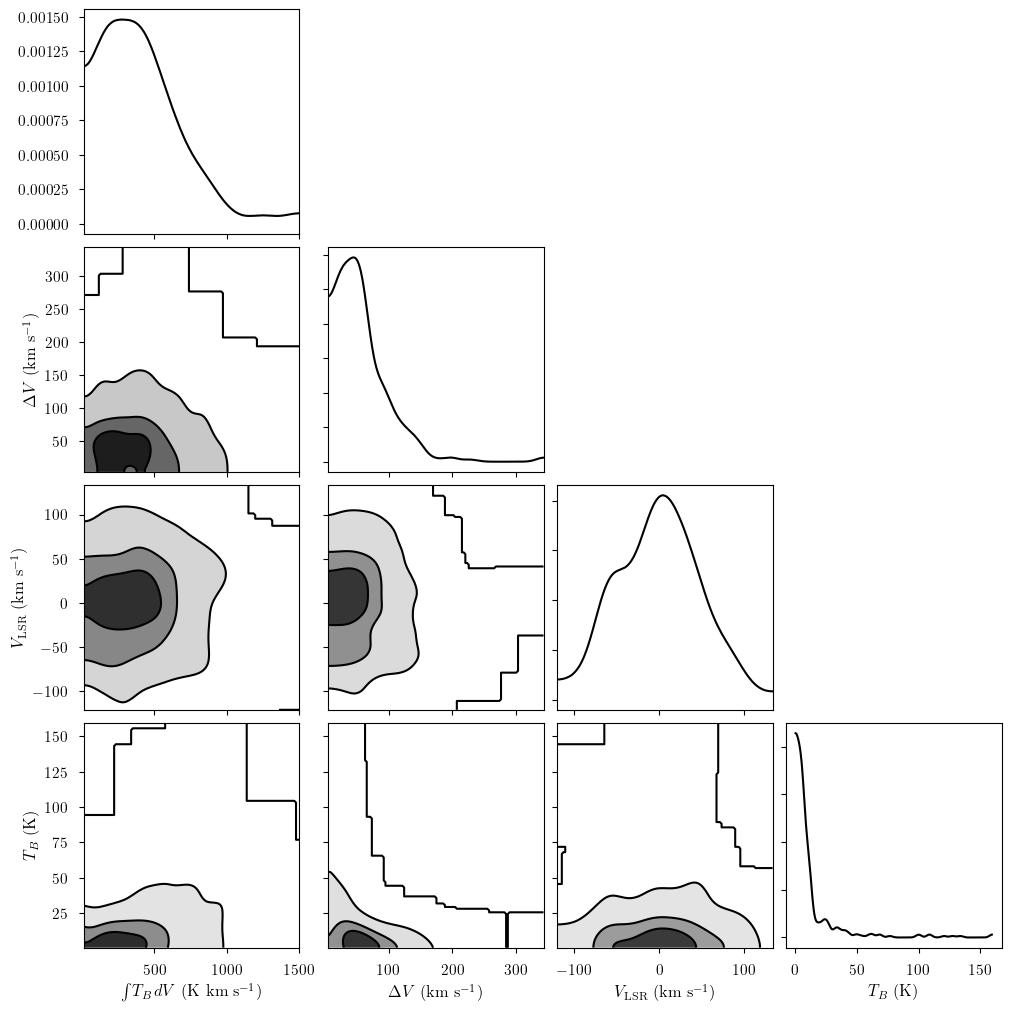

In [8]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

var_names = model.cloud_deterministics
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

## Posterior Sampling: MCMC

In [9]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.05, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4400
Interrupted at 4,399 [4%]: Average Loss = 986.03
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Adding log-likelihood to trace


Output()

In [10]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [11]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.364,0.286,8.857,9.929,0.004,0.003,5349.0,2881.0,1.0
amplitude[1],4.598,0.275,4.084,5.094,0.005,0.004,3432.0,2454.0,1.0
amplitude[2],3.427,0.296,2.897,4.013,0.005,0.004,3327.0,2920.0,1.0
baseline_observation_norm[0],-0.656,0.071,-0.786,-0.524,0.001,0.001,2899.0,3010.0,1.0
baseline_observation_norm[1],-1.808,0.156,-2.083,-1.503,0.002,0.002,4791.0,3040.0,1.0
baseline_observation_norm[2],0.950,0.874,-0.593,2.705,0.016,0.012,2998.0,2918.0,1.0
fwhm[0],26.090,1.070,24.066,28.036,0.022,0.015,2435.0,2703.0,1.0
fwhm[1],33.576,3.082,27.625,39.192,0.071,0.051,1823.0,2331.0,1.0
fwhm[2],30.992,5.912,21.484,41.834,0.168,0.126,1470.0,1224.0,1.0
fwhm_norm[0],0.870,0.036,0.802,0.935,0.001,0.001,2435.0,2703.0,1.0


Sampling: [observation]


Output()

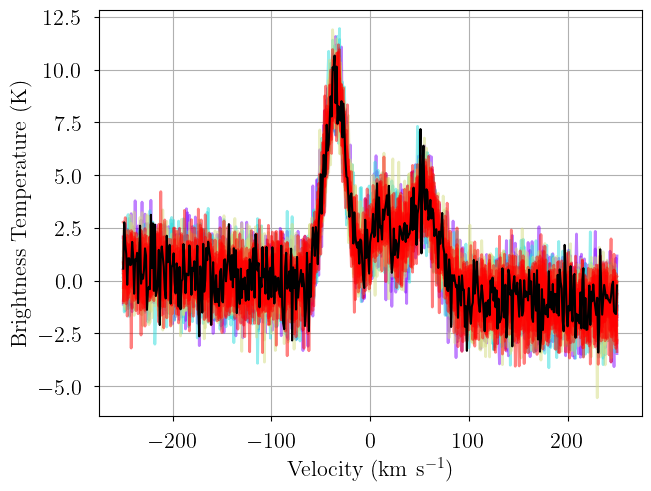

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

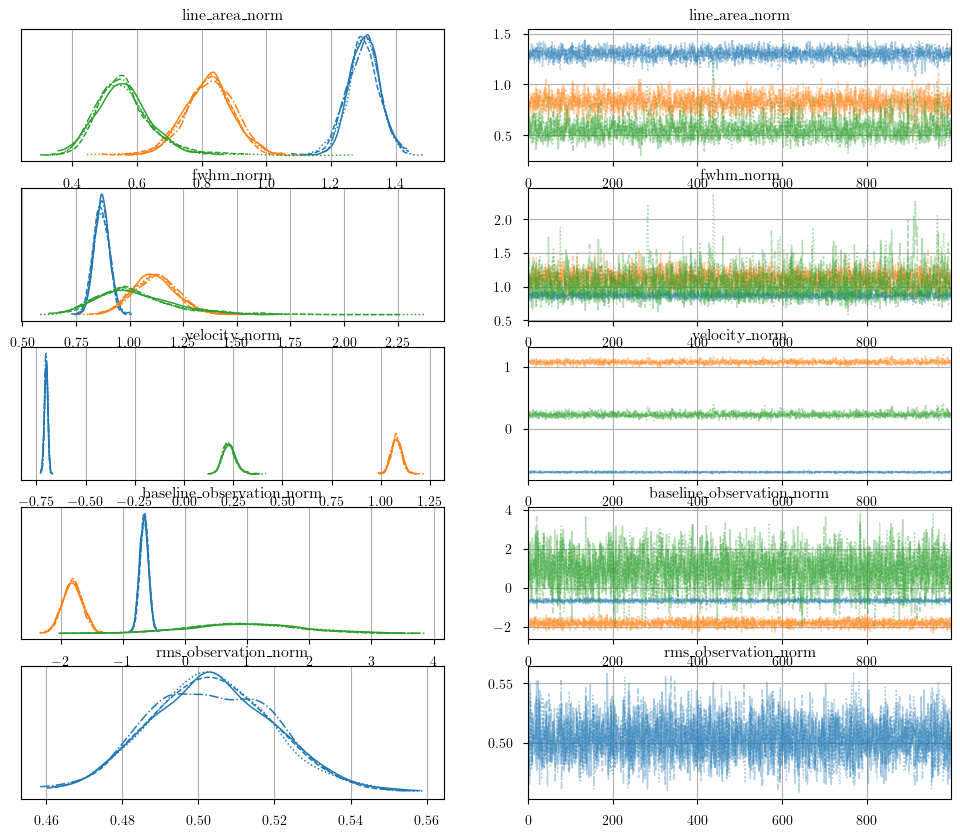

In [13]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)